# Detecting Tumor on CT+MRI scans using ResNet
 

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda
True
1
0
NVIDIA GeForce RTX 4060 Laptop GPU



Image 1 Shape: (640, 640)
Image 2 Shape: (640, 640)
Image 3 Shape: (640, 640)
Image 4 Shape: (640, 640)
Image 5 Shape: (640, 640)


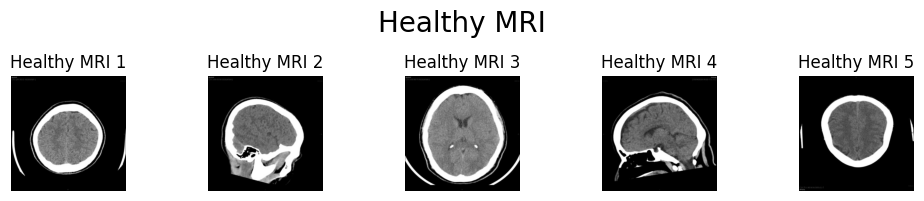

Image 1 Shape: (640, 640)
Image 2 Shape: (640, 640)
Image 3 Shape: (640, 640)
Image 4 Shape: (640, 640)
Image 5 Shape: (640, 640)


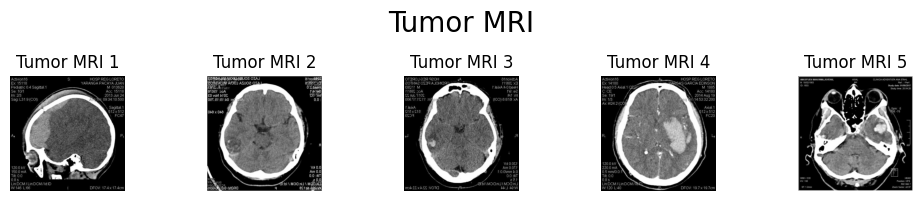

Image 1 Shape: (256, 256)
Image 2 Shape: (256, 256)
Image 3 Shape: (528, 581)
Image 4 Shape: (256, 256)
Image 5 Shape: (512, 512)


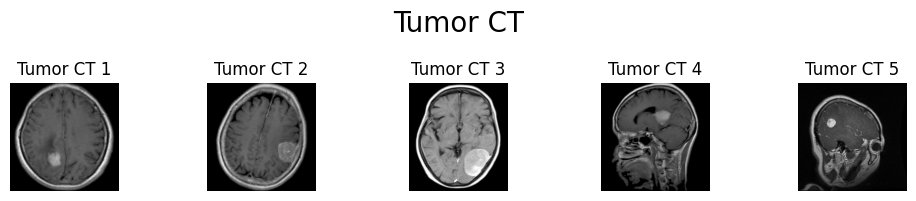

Image 1 Shape: (236, 366)
Image 2 Shape: (232, 216)
Image 3 Shape: (228, 221)
Image 4 Shape: (442, 442)
Image 5 Shape: (236, 366)


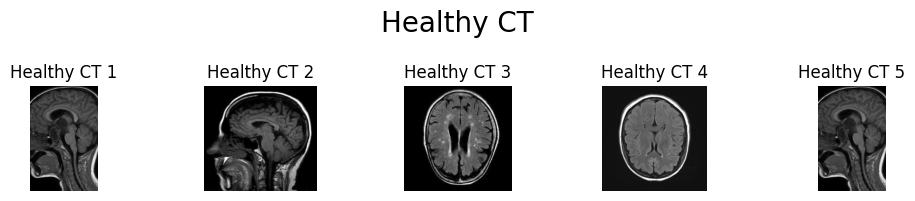

In [ ]:
dataset_path = "Dataset"

mri_tumor_path = os.path.join(dataset_path, "Brain Tumor CT scan Images", "Tumor")
mri_healthy_path = os.path.join(dataset_path, "Brain Tumor CT scan Images", "Healthy")
ct_tumor_path = os.path.join(dataset_path, "Brain Tumor MRI Images", "Tumor")
ct_healthy_path = os.path.join(dataset_path, "Brain Tumor MRI Images", "Healthy")

def display_images_from_path(path, title="Images", num_images=5):
    images = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(('png', 'jpg', 'jpeg'))]
    plt.figure(figsize=(10, 2))
    plt.suptitle(title, fontsize=20)
    random_images = random.sample(images, min(num_images, len(images)))
    for i, image_path in enumerate(random_images):
        img = Image.open(image_path)  
        print(f"Image {i + 1} Shape: {img.size}")
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray') 
        plt.axis('off')
        plt.title(f"{title} {i + 1}")
    plt.tight_layout()
    plt.show()
print("")
display_images_from_path(mri_healthy_path, title="Healthy MRI")
display_images_from_path(mri_tumor_path, title="Tumor MRI")
display_images_from_path(ct_tumor_path, title="Tumor CT")
display_images_from_path(ct_healthy_path, title="Healthy CT")


**Prosses Images**

Processed CT Image 1 Shape: (256, 256)
Processed CT Image 2 Shape: (256, 256)
Processed CT Image 3 Shape: (256, 256)
Processed MRI Image 1 Shape: (256, 256)
Processed MRI Image 2 Shape: (256, 256)
Processed MRI Image 3 Shape: (256, 256)


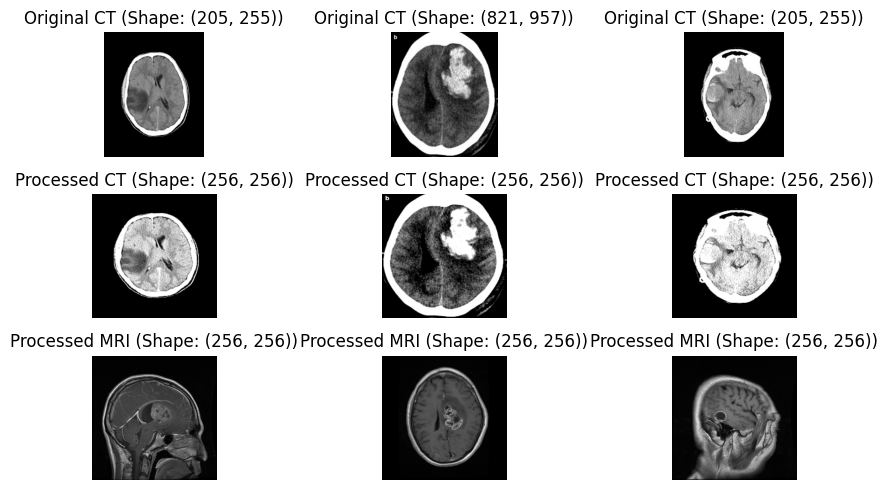

In [20]:

def adjust_image(image, brightness_factor=1.2, contrast_factor=1.5, size=(256, 256), sharpness_factor=1.5):
    image = image.convert("L")
    # Enhance brightness
    enhancer_brightness = ImageEnhance.Brightness(image)
    image = enhancer_brightness.enhance(brightness_factor)
    
    # Enhance contrast
    enhancer_contrast = ImageEnhance.Contrast(image)
    image = enhancer_contrast.enhance(contrast_factor)
    
    # Enhance sharpness
    enhancer_sharpness = ImageEnhance.Sharpness(image)
    image = enhancer_sharpness.enhance(sharpness_factor)
    
    # Resize image
    image = image.resize(size)
    return image

def preprocess_and_display(ct_path, mri_path, output_path, size=(256, 256), num_images=3, show_images=False):
    # Load CT and MRI images
    ct_images = [os.path.join(ct_path, f) for f in os.listdir(ct_path) if f.endswith(('png', 'jpg', 'jpeg'))]
    mri_images = [os.path.join(mri_path, f) for f in os.listdir(mri_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    # Process and save all images
    for i, image_path in enumerate(ct_images):
        with Image.open(image_path) as img:
            processed_img = adjust_image(img, size=size)
            processed_img.save(os.path.join(output_path, f"CT_Processed_{i}.png"), format='PNG')

    for i, image_path in enumerate(mri_images):
        with Image.open(image_path) as img:
            processed_img = adjust_image(img, brightness_factor=1, contrast_factor=1, size=size, sharpness_factor=1.5)
            processed_img.save(os.path.join(output_path, f"MRI_Processed_{i}.png"), format='PNG')

    if show_images:
        # Display CT Original and Processed
        plt.figure(figsize=(10, 5))
        for i in range(num_images):
            with Image.open(ct_images[i]) as ct_img:
                plt.subplot(3, num_images, i + 1)
                plt.imshow(ct_img, cmap='gray')
                plt.axis('off')
                plt.title(f"Original CT (Shape: {ct_img.size})")

            with Image.open(ct_images[i]) as ct_img:
                processed_ct_img = adjust_image(ct_img, size=size)
                plt.subplot(3, num_images, num_images + i + 1)
                plt.imshow(processed_ct_img, cmap='gray')
                plt.axis('off')
                plt.title(f"Processed CT (Shape: {size})")
                

        # Display MRI Processed
        for i in range(num_images):
            with Image.open(mri_images[i]) as mri_img:
                processed_mri_img = adjust_image(mri_img, brightness_factor=1, contrast_factor=1, size=size)
                plt.subplot(3, num_images, 2 * num_images + i + 1)
                plt.imshow(processed_mri_img, cmap='gray')
                plt.axis('off')
                plt.title(f"Processed MRI (Shape: {size})")
                
                
        plt.tight_layout()
        plt.show()

# Paths
output_pathT  = "Processed_Images/Tumor"
output_pathH = "Processed_Images/Healthy"

# Create output directory if it doesn't exist
os.makedirs(output_pathT, exist_ok=True)
os.makedirs(output_pathH, exist_ok=True)

# Call the function
preprocess_and_display(mri_tumor_path, ct_tumor_path, output_pathT, size=(256, 256), num_images=3, show_images=True)
preprocess_and_display(mri_healthy_path, ct_healthy_path, output_pathH, size=(256, 256), num_images=3, show_images=False)


**Split Train&Test&Validation**

In [9]:
processed_path = "Processed_Images"
output_base_path = "Dataset_Split"
subfolders = ['train', 'val', 'test']
categories = ['Healthy', 'Tumor']


for subfolder in subfolders:
    for category in categories:
        os.makedirs(os.path.join(output_base_path, subfolder, category), exist_ok=True)

def split_and_copy_images(base_path, category_name, output_base_path, train_ratio=0.7, val_ratio=0.2):
    images = [os.path.join(base_path, f) for f in os.listdir(base_path) if f.endswith(('png', 'jpg', 'jpeg'))]
    train, temp = train_test_split(images, test_size=1 - train_ratio, random_state=42)
    val, test = train_test_split(temp, test_size=val_ratio / (1 - train_ratio), random_state=42)


    for img_path in train:
        shutil.copy(img_path, os.path.join(output_base_path, 'train', category_name))
    for img_path in val:
        shutil.copy(img_path, os.path.join(output_base_path, 'val', category_name))
    for img_path in test:
        shutil.copy(img_path, os.path.join(output_base_path, 'test', category_name))

# חלוקה עבור כל קטגוריה
split_and_copy_images(os.path.join(processed_path, 'Healthy'), 'Healthy', output_base_path)
split_and_copy_images(os.path.join(processed_path, 'Tumor'), 'Tumor', output_base_path)

print("Dataset has been split into Train, Validation, and Test sets.")


Dataset has been split into Train, Validation, and Test sets.


**Create DataLoder**

In [2]:

# Transformations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Paths
train_path = "Dataset_Split/train"
val_path = "Dataset_Split/val"
test_path = "Dataset_Split/test"

# Load datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 7695
Validation dataset size: 1236
Test dataset size: 2444


In [3]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, current_score):

        if self.best_score is None:
            self.best_score = current_score
        elif self._is_improvement(current_score):
            self.best_score = current_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def _is_improvement(self, current_score):
        if self.mode == 'min':
            return current_score < self.best_score - self.min_delta
        elif self.mode == 'max':
            return current_score > self.best_score + self.min_delta
        else:
            raise ValueError("Invalid mode. Use 'min' or 'max'.")

cuda


C:\Users\lidor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\lidor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Train Loss: 0.3071, Train Acc: 87.36%, Val Loss: 0.1511, Val Acc: 93.77%
Validation Loss: 0.1511, Early Stopping Counter: 0
Epoch [2/30], Train Loss: 0.1713, Train Acc: 93.22%, Val Loss: 0.2399, Val Acc: 91.02%
Validation Loss: 0.2399, Early Stopping Counter: 0
Epoch [3/30], Train Loss: 0.1349, Train Acc: 95.07%, Val Loss: 0.2066, Val Acc: 91.34%
Validation Loss: 0.2066, Early Stopping Counter: 1
Epoch [4/30], Train Loss: 0.1026, Train Acc: 96.22%, Val Loss: 0.0726, Val Acc: 96.84%
Validation Loss: 0.0726, Early Stopping Counter: 2
Epoch [5/30], Train Loss: 0.0811, Train Acc: 96.93%, Val Loss: 0.0502, Val Acc: 98.14%
Validation Loss: 0.0502, Early Stopping Counter: 0
Epoch [6/30], Train Loss: 0.0716, Train Acc: 97.45%, Val Loss: 0.0515, Val Acc: 98.30%
Validation Loss: 0.0515, Early Stopping Counter: 0
Epoch [7/30], Train Loss: 0.0770, Train Acc: 97.18%, Val Loss: 0.0732, Val Acc: 97.90%
Validation Loss: 0.0732, Early Stopping Counter: 1
Epoch [8/30], Train Loss: 0.0667, 

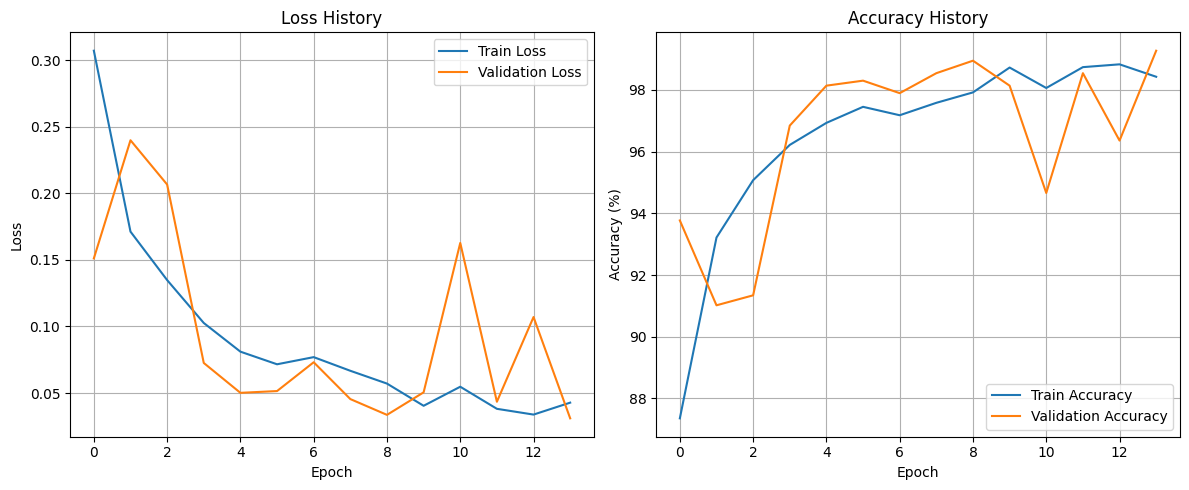

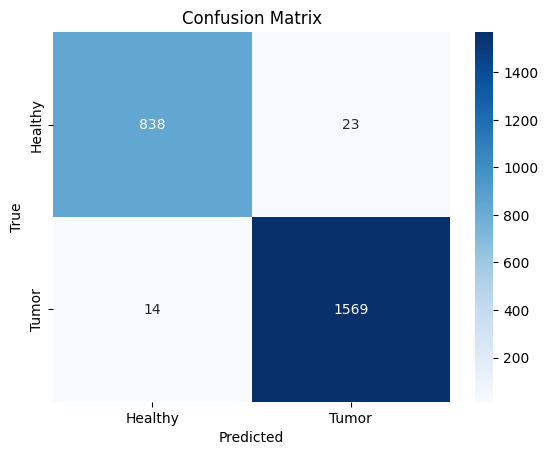

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.98      0.97      0.98       861
       Tumor       0.99      0.99      0.99      1583

    accuracy                           0.98      2444
   macro avg       0.98      0.98      0.98      2444
weighted avg       0.98      0.98      0.98      2444



In [4]:
print(device)
class CustomResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)

        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


learning_rate = 0.001
epochs = 30
model = CustomResNet(num_classes=2).to(device)
early_stopping = EarlyStopping(patience=5, min_delta=0.01, mode='min')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train_and_evaluate():
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100 * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = 100 * val_correct / val_total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Early Stopping Counter: {early_stopping.counter}")

        # Check for Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_and_evaluate()

plt.figure(figsize=(12, 5))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.grid(True) 

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy History')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# הפקת טבלת בלבול ודוח ביצועים
conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Tumor'], yticklabels=['Healthy', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Healthy', 'Tumor']))


**Test**

Test Loss: 0.0566, Test Accuracy: 98.49%


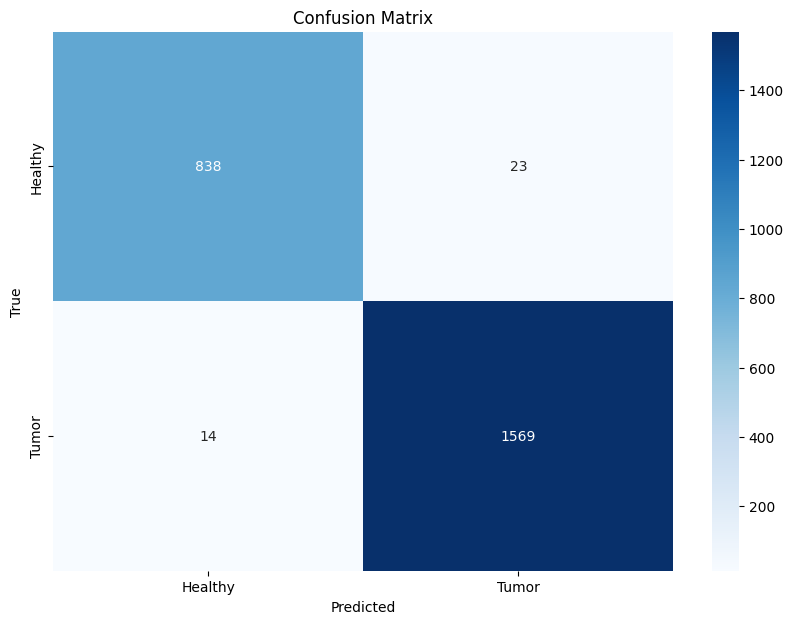

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.98      0.97      0.98       861
       Tumor       0.99      0.99      0.99      1583

    accuracy                           0.98      2444
   macro avg       0.98      0.98      0.98      2444
weighted avg       0.98      0.98      0.98      2444



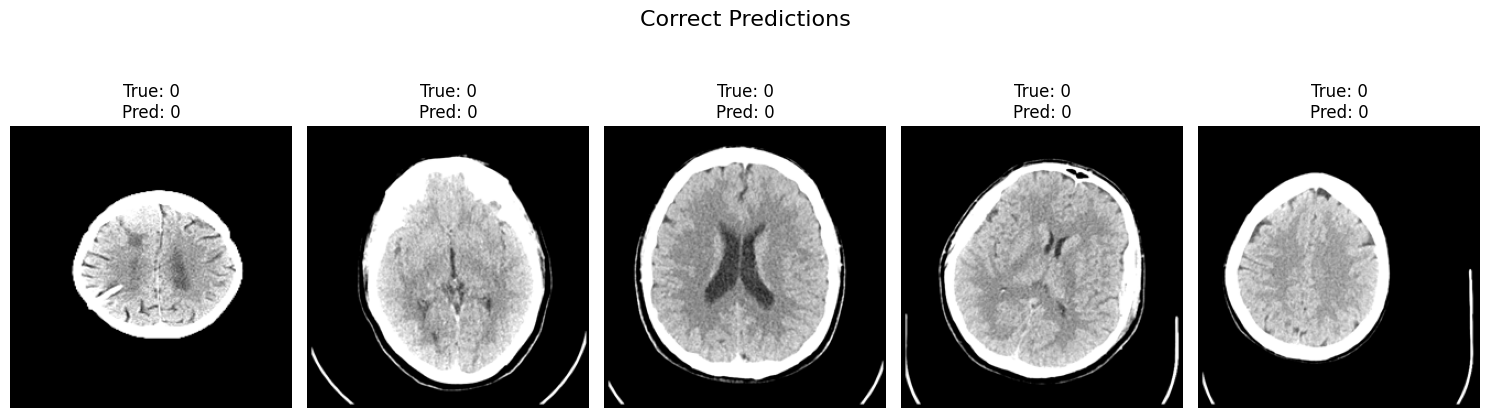

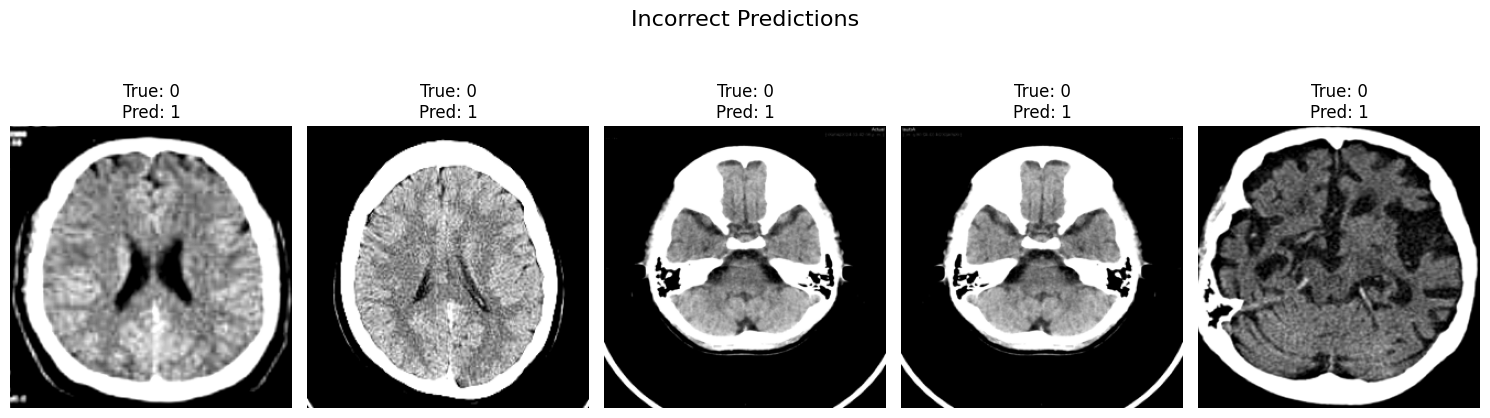

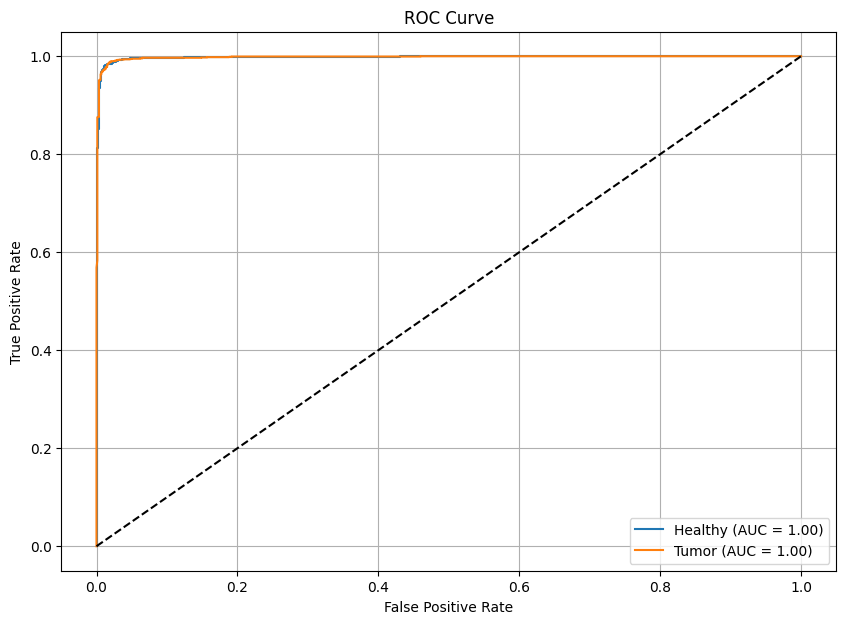

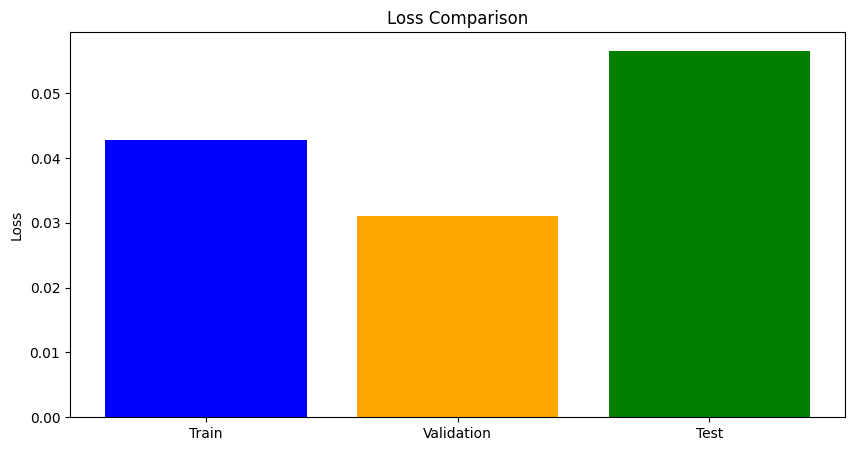

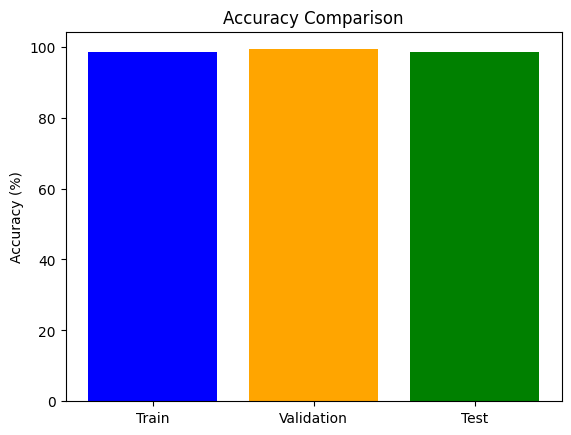

In [12]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def display_samples(images, labels, predictions, title=""): 
    plt.figure(figsize=(15, 5))
    for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {label}\nPred: {prediction}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

model.eval()
all_preds, all_labels = [], []
all_probs = []
correct_images, correct_labels, correct_preds = [], [], []
incorrect_images, incorrect_labels, incorrect_preds = [], [], []
test_loss, test_correct, test_total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        for i in range(len(labels)):
            image = images[i].cpu().squeeze(0).numpy()
            if preds[i] == labels[i]:
                if len(correct_images) < 5: 
                    correct_images.append(image)
                    correct_labels.append(labels[i].cpu().item())
                    correct_preds.append(preds[i].cpu().item())
            else:
                if len(incorrect_images) < 5:  
                    incorrect_images.append(image)
                    incorrect_labels.append(labels[i].cpu().item())
                    incorrect_preds.append(preds[i].cpu().item())

        test_total += labels.size(0)
        test_correct += (preds == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_acc = 100 * test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


display_samples(correct_images, correct_labels, correct_preds, title="Correct Predictions")
display_samples(incorrect_images, incorrect_labels, incorrect_preds, title="Incorrect Predictions")

# ROC Curve
binarized_labels = np.eye(len(train_dataset.classes))[np.array(all_labels)]
plt.figure(figsize=(10, 7))
for i, class_name in enumerate(train_dataset.classes):
    fpr, tpr, _ = roc_curve(binarized_labels[:, i], np.array(all_probs)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))

# Loss
plt.bar(['Train', 'Validation', 'Test'], [train_loss_history[-1], val_loss_history[-1], test_loss], color=['blue', 'orange', 'green'])
plt.title("Loss Comparison")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.bar(['Train', 'Validation', 'Test'], [train_acc_history[-1], val_acc_history[-1], test_acc], color=['blue', 'orange', 'green'])
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.show()
####